In [4]:
%pylab inline

import seaborn as sns
import numpy as np

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.source.event import get_event
from sigvisa import Sigvisa

import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# load sg from saved dump
with open("global_hough_tuning_30stas.pkl.sg", 'rb') as f:
    sg_inferred = pickle.load(f)

/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


In [5]:
from sigvisa.infer.propose_hough import CTFProposer, get_uatemplates, \
                    global_hough,normalize_global,visualize_hough_array, \
                    score_assoc, station_hough

import time

def global_hough_standin(sg, hc, uatemplates_by_sta):
    t0 = time.time()
    global_array = hc.create_array(dtype=np.float32, fill_val=0.0)
    global_debug = {}
    global_noev_ll = 0
    t1 = time.time()

    sta_hough_time = 0
    adj_time = 0

    sta_arrays = {}
    sta_nlls = {}
    for wn, uatemplates in uatemplates_by_sta.items():
        sta = wn.sta
        t2 = time.time()
        sta_array, assocs, phase_scores, null_ll = station_hough(sg, hc, wn, uatemplates, fill_assoc=False)
        t3 = time.time()
        sta_hough_time += t3-t2

        global_debug[wn.label]=(assocs, phase_scores, null_ll)
        global_array += sta_array
        global_noev_ll += null_ll
        t4 = time.time()
        adj_time += t4-t3

        #sta_array = np.exp(sta_array - np.max(sta_array))
        sta_arrays[wn.sta] = sta_array.copy()
        sta_nlls[wn.sta] = null_ll

        global_lik = normalize_global(global_array.copy(), global_noev_ll, one_event_semantics=False, hc=hc)
        global_dist = normalize_global(global_array.copy(), global_noev_ll, one_event_semantics=True, hc=hc)

    t5 = time.time()
    print "global hough: init %f stahough %f adj %f total %f" % (t1-t0, sta_hough_time, adj_time, t5-t0)
    return global_array, global_debug, global_noev_ll, sta_arrays, sta_nlls

def get_hough_array(sg, hc, uatemplates_by_sta):
    global_array,assocs, nll, sta_arrays, sta_nlls = global_hough_standin(sg, hc, uatemplates_by_sta)
    global_dist = normalize_global(global_array.copy(), nll, one_event_semantics=True, hc=hc)

    return global_array, global_dist, assocs, nll, sta_arrays, sta_nlls

In [6]:
ctf = CTFProposer(sg_inferred, bin_widths=[3.0, 1.5, 0.75, 0.38], phases=("P", ),
                  depthbin_bounds=[0,10,50,150,400,700],
                  mbbins=[12,2,2,2], offset=0.0, min_mb=sg_inferred.min_mb)
uatemplates_by_sta_full = get_uatemplates(sg_inferred)

"""
subset_stas = ("WR1", "TX01","IL31", "PD31", "AS12")
uatemplates_by_sta = {}
for sta in subset_stas:
    for k in uatemplates_by_sta_full.keys():
        if k.sta==sta:
            uatemplates_by_sta[k] = uatemplates_by_sta_full[k]
            break
"""

uatemplates_by_sta = uatemplates_by_sta_full
            

/home/dmoore/python/sigvisa/models/signal_model.py:662: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [ ]:

#true_bins, true_evs = get_hough_bins(sg_leb, ctf.global_hc, uatemplates_by_sta)
global_array, global_dist, assocs, nll, sta_arrays, sta_nlls = get_hough_array(sg_inferred, ctf.global_hc, uatemplates_by_sta)

ARA0
IL31
TOA0
AFI
PD31
AS12
BR131
STKA
URZ
MK31
YKR8
ZAA0
CM16
LPAZ
SIV
SONA0
PMG
BVA0
KURBB
CTA


In [13]:
for sta in sta_arrays.keys():
    sta_arrays[sta] = sta_arrays[sta].copy()

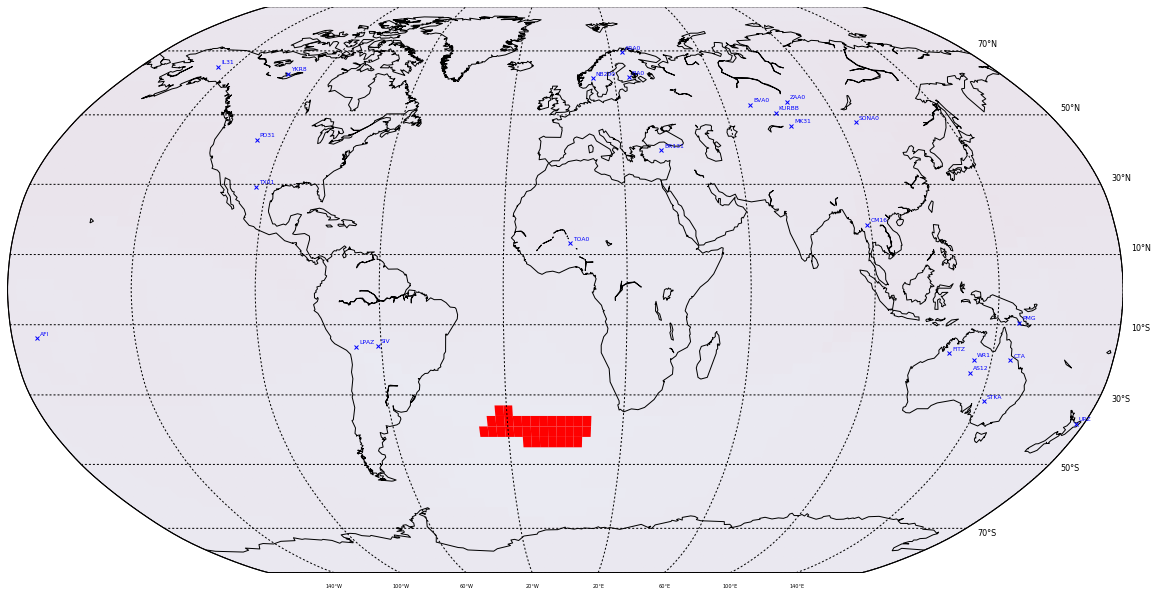

In [15]:
f = plt.figure(figsize=(20, 15))
ax = f.add_subplot(111)

visualize_hough_array(global_array, 
                      sta_arrays.keys(), 
                      ax=ax, timeslice=None, 
                      region=sg_inferred.inference_region)


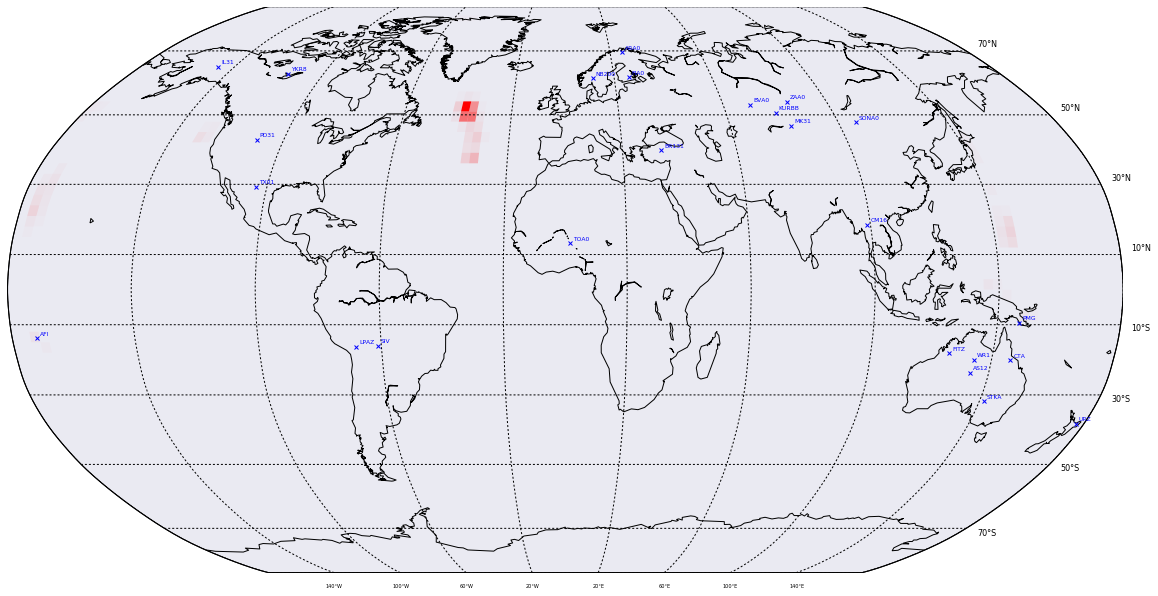

In [16]:
f = plt.figure(figsize=(20, 15))
ax = f.add_subplot(111)

visualize_hough_array(global_dist, 
                      sta_arrays.keys(), 
                      ax=ax, timeslice=None, 
                      region=sg_inferred.inference_region)


In [82]:
print [k.sta for k in uatemplates_by_sta.keys()]

['BVA0', 'WR1', 'CTA', 'TOA0', 'FITZ', 'PD31', 'FIA0', 'NB200', 'TX01', 'ARA0', 'IL31', 'MK31', 'AFI', 'CM16', 'PMG', 'AS12', 'BR131', 'STKA', 'URZ', 'LPAZ', 'KURBB', 'ZAA0', 'YKR8', 'SIV', 'SONA0']


In [42]:
subset_stas = set( ("PD31", "AS12", "WR1", "TX01","IL31", ) + tuple([k.sta for k in uatemplates_by_sta.keys()][:30]))
#print subset_stas
#subset_stas.add("YKR8")

#subset_stas = set(tuple([k.sta for k in uatemplates_by_sta.keys()]))
#subset_stas.remove("ZAA0")
#subset_stas.remove("YKR8")

garray = ctf.global_hc.create_array(dtype=np.float32, fill_val=0.0)
gnll = 0.0
for sta, sarray in sta_arrays.items():
    if sta in subset_stas:
        print "added", sta
        garray += np.where(sarray > sta_nlls[sta] - 5, sarray, sta_nlls[sta]-5)
        gnll = sta_nlls[sta]
        
gall = normalize_global(garray, gnll, one_event_semantics=True, hc=ctf.global_hc)
#gall2 = normalize_global(garray + sta_arrays["ZAA0"], gnll + sta_nlls["ZAA0"], one_event_semantics=True, hc=ctf.global_hc)

added CM16
added LPAZ
added MK31
added CTA
added SIV
added TX01
added BVA0
added PMG
added AS12
added WR1
added SONA0
added FIA0
added AFI
added STKA
added BR131
added YKR8
added FITZ
added IL31
added URZ
added ARA0
added ZAA0
added PD31
added NB200
added TOA0
added KURBB


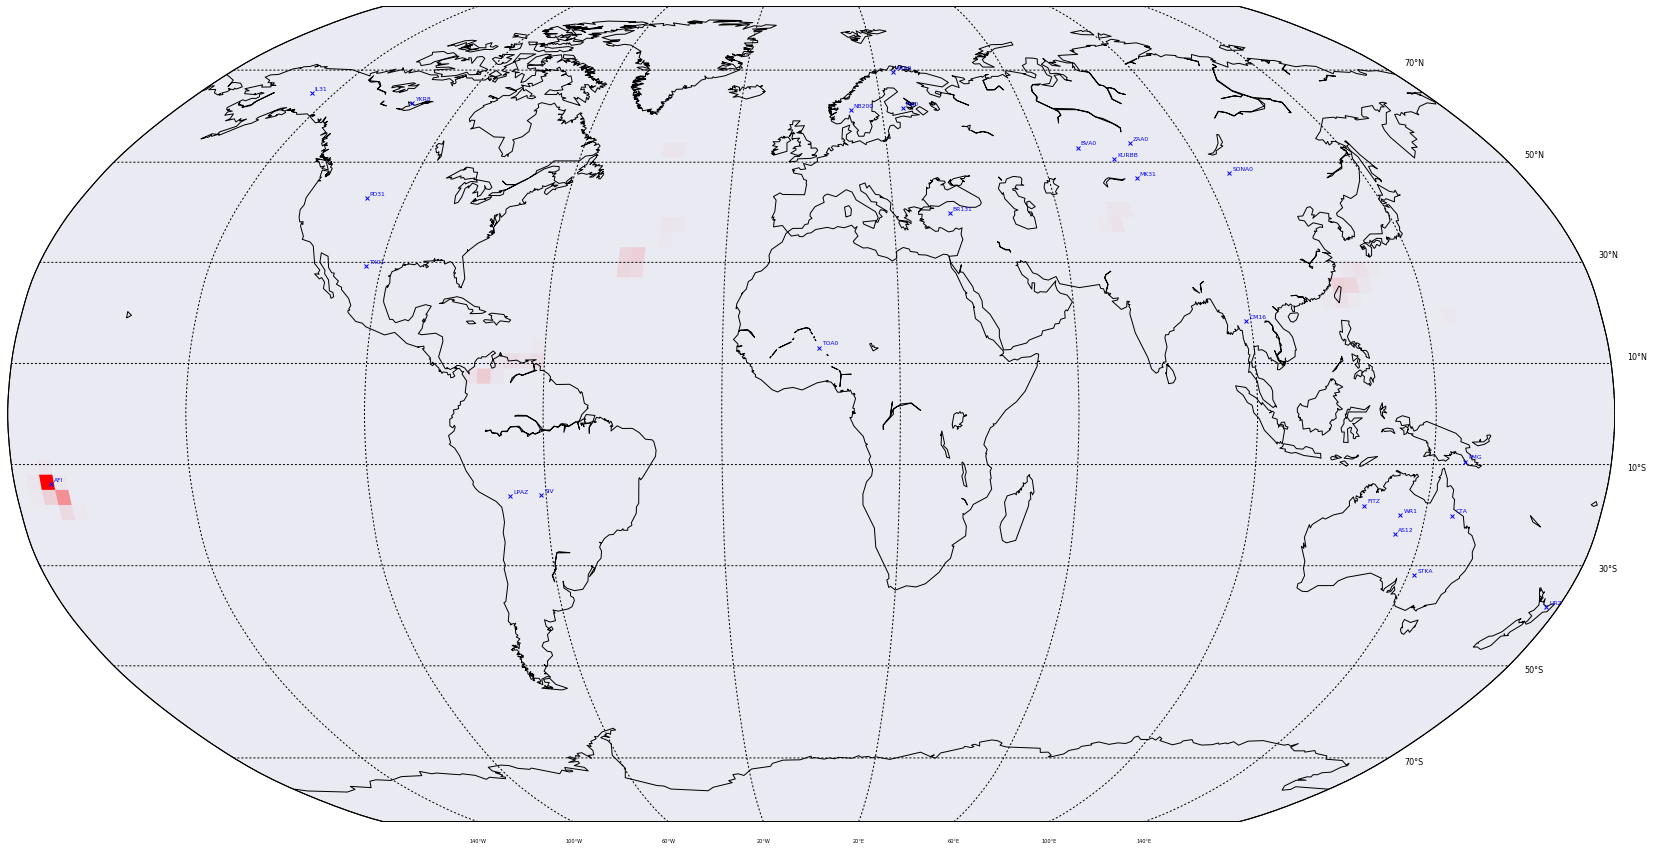

In [43]:
f = plt.figure(figsize=(30, 15))
ax = f.add_subplot(111)

visualize_hough_array(gall, 
                      subset_stas, 
                      ax=ax, timeslice=None, 
                      region=sg_inferred.inference_region)




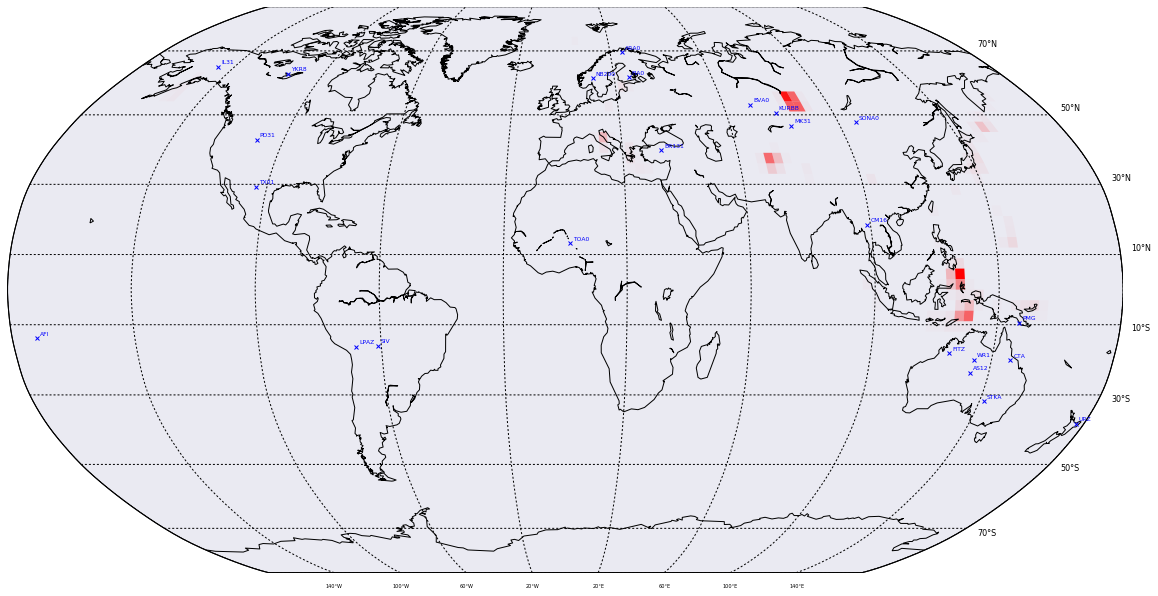

In [35]:
gsta = normalize_global(sta_arrays["ZAA0"].copy(), sta_nlls["ZAA0"], one_event_semantics=True, hc=ctf.global_hc)
f = plt.figure(figsize=(20, 15))
ax = f.add_subplot(111)

visualize_hough_array(gsta, 
                      subset_stas, 
                      ax=ax, timeslice=None, 
                      region=sg_inferred.inference_region)


In [34]:
for k, arr in sorted(sta_arrays.items()):
    print k, np.min(arr), np.max(arr), sta_nlls[k]

AFI -57.511 -27.6936 -39.090338761
ARA0 -51.3185 -28.4981 -32.8978213154
AS12 -83.7615 -71.2724 -76.6013837389
BR131 -70.061 -58.191 -66.6080509195
BVA0 -9.82804 -0.00200001 -0.002
CM16 -133.096 -125.916 -129.555820215
CTA -22.041 -10.7688 -15.0170701233
FIA0 -25.8024 -7.7 -7.7
FITZ -48.3151 -26.3847 -29.8944013501
IL31 -131.664 -106.127 -113.243149806
KURBB -0.219895 -0.21985 -0.21985
LPAZ -90.9601 -75.8382 -85.8819797492
MK31 -72.859 -58.7742 -66.1417912593
NB200 -55.3718 -29.9818 -36.9511641179
PD31 -87.6243 -67.4677 -80.9290358315
PMG -31.7487 -11.7401 -25.5232349964
SIV -16.6349 -9.81047 -13.4547821377
SONA0 -176.795 -158.033 -166.981485108
STKA -57.2425 -48.1985 -53.904319339
TOA0 -69.6149 -57.158 -66.325819878
TX01 -150.88 -119.28 -132.459055505
URZ -24.1007 -5.68 -5.68
WR1 -100.846 -89.454 -96.3001253477
YKR8 -126.818 -104.989 -121.589895196
ZAA0 -169.54 -129.882 -135.675904377
